In [1]:
import torch
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#reading in images to arrays
def image_arrs(paths, im_arr):
    for path in paths:
        image = cv2.imread(path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize
        size_image = image_from_array.resize((30,30))
        image_arr = np.array(size_image.getdata(),np.uint8).reshape(size_image.size[1], size_image.size[0],3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [3]:
#given code
#all file paths from classes 1-5
df = pd.read_csv('Train.csv')

paths1 = df[(df['ClassId'] ==1)]['Path'].values
paths2 = df[(df['ClassId'] ==2)]['Path'].values
paths3 = df[(df['ClassId'] ==3)]['Path'].values
paths4 = df[(df['ClassId'] ==4)]['Path'].values
paths5 = df[(df['ClassId'] ==5)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

class4_arrs = []
class4_arrs = image_arrs(paths4, class4_arrs)

class5_arrs = []
class5_arrs = image_arrs(paths5, class5_arrs)

In [4]:
#given code
#concat data/labels
X = class1_arrs + class2_arrs + class3_arrs + class4_arrs + class5_arrs
y = (len(class1_arrs)*[0]) + (len(class2_arrs)*[1]) + (len(class3_arrs)*[2]) + (len(class4_arrs)*[3]) \
        + (len(class5_arrs)*[4])


In [5]:
#given code - split data
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state = 0)

In [9]:
print(X_train[0][:10])
print(X_test[0][:10])
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train[0][:10])
print(X_test[0][:10])

[255 255 255 255 255 255 255 255 255 255]
[77 75 74 78 75 73 83 79 83 86]
[2.17613453 2.18862266 2.15660765 2.17372139 2.18763757 2.15522839
 2.16848531 2.17943235 2.1348052  2.17871515]
[-0.09824613 -0.15561599 -0.20655069 -0.08334241 -0.15359129 -0.22391741
 -0.02113209 -0.10096684 -0.0979058   0.01741677]


In [10]:
#given code - convert from np array to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [11]:
#create training and testing sets
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
test_data = [(X_test[i], y_test[i]) for i in range(len(X_test))]

print(len(train_data))
    
trainset = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testset = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

7776


<h3> Build NN 

In [12]:
class Net(nn.Module):
    
    #define layers
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2700, 30)
        self.fc2 = nn.Linear(30,60)
        self.fc4 = nn.Linear(60,90)
        self.fc5 = nn.Linear(90,5)
        
    #passing through each layer
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
    
        return F.log_softmax(x, dim=1)
        
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2700, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=90, bias=True)
  (fc5): Linear(in_features=90, out_features=5, bias=True)
)


In [13]:
#random input to make sure it works
randoms = torch.rand(2700)
randoms = randoms.view(-1, 2700)

output = net(randoms)
print(output)

tensor([[-1.6271, -1.5803, -1.5760, -1.6083, -1.6578]],
       grad_fn=<LogSoftmaxBackward>)


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [902]:
optimizer = optim.Adam(net.parameters(), lr=0.000075, weight_decay=0.00005)
criterion = nn.CrossEntropyLoss()

EPOCHS = 150
loss_vals = []

for epoch in range(EPOCHS):
    for data in trainset:
        X,y = data
        #want gradient to be 0 each time
        net.zero_grad()
        output = net(X.view(-1,2700))
        loss = criterion(output, y)
        #backpropagating the loss
        loss.backward()
        #taking the steps to decrease loss
        optimizer.step()
    if epoch%10 == 0: print(loss)
    loss_vals.append(loss)
        

tensor(1.3606, grad_fn=<NllLossBackward>)
tensor(0.5263, grad_fn=<NllLossBackward>)
tensor(0.2446, grad_fn=<NllLossBackward>)
tensor(0.1852, grad_fn=<NllLossBackward>)
tensor(0.0974, grad_fn=<NllLossBackward>)
tensor(0.0266, grad_fn=<NllLossBackward>)
tensor(0.0191, grad_fn=<NllLossBackward>)
tensor(0.0095, grad_fn=<NllLossBackward>)
tensor(0.0038, grad_fn=<NllLossBackward>)
tensor(0.0251, grad_fn=<NllLossBackward>)
tensor(0.0080, grad_fn=<NllLossBackward>)
tensor(0.0028, grad_fn=<NllLossBackward>)
tensor(0.0020, grad_fn=<NllLossBackward>)
tensor(0.0210, grad_fn=<NllLossBackward>)
tensor(0.0051, grad_fn=<NllLossBackward>)


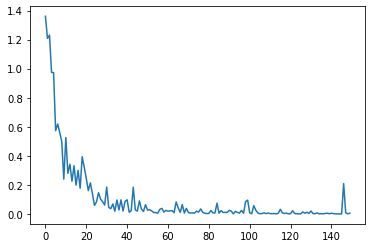

In [903]:
plt.plot(range(len(loss_vals)), loss_vals)

In [914]:
#see training accuracy
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X,y = data
        output = net(X.view(-1, 2700))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct+=1
            total+=1

print('Train Accuracy', round(correct/total, 3))


Train Accuracy 0.999


In [915]:
#for test
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        output = net(X.view(-1,2700))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct+=1
            total+=1

print('Test accuracy', round(correct/total, 3))

Test accuracy 0.942
